# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #7
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 23th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import uniform
from scipy.stats import gamma
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [21]:
# data_df is the dataframe of your data
# estimates_df is a numpy array of cancer rate estimates, one for each county
def scatter_plot_cancer_rates(data_df, estimates):
    ax = data_df.plot(kind='scatter', x="pop",y="pct_mortality", alpha=0.05, color="grey")
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="blue", ax=ax, logx=True)
    bot_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="red", ax=ax, logx=True)
    ax.plot(data_df['pop'], 5 * estimates, '.', alpha=0.04, color="green")
    ax.set_ylim([-0.0001, 0.0003])

## Problem 1: Kidney Cancer Data Revisited
In this problem we will work with the US Kidney Cancer Data set (by county). This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

In lecture, we've discussed the potential (and significant) draw backs of drawing conclusions based on raw cancer rates. Addressing these draw backs, we proposed using a Bayesian model to model the data. In the following, you will implement two Bayesian models and examine the adjusted cancer rates per county resulting from these models.

### Part A: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

- Using Empirical Bayes and moment matching, choose appropriate values for the hyperparameters.



- Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green. 

(**Note:** This is the plot shown in the lecture notes for this dataset. We have provided the code to produce this plot, which you are free to use or to ignore.)



- Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might find it helpful to review the in-class discussion on this dataset. You might also find it helpful to follow the Rat Tumor Baysian model example.)

**Solution:**

### 1. Closed Forms for the Posterior and Predictive Distributions
We note that the Gamma-Poisson model is conjugate, that is, the posterior, posterior predictive and prior predictive all have closed forms. In particular, the posterior distribution is a Gamma distribution and the prior predictive is a Negative Binomial Distribution. Since the Poisson distribution 

\begin{align}
p(\theta_j | y_j) &\propto Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)\\
&\propto e^{-5 \cdot n_j \cdot \theta_j} \left(5 \cdot n_j \cdot \theta_j\right)^{y_j} \theta_j^{\alpha - 1} e^{-\beta\theta_j}\\
&= e^{-\left(5 \cdot n_j \cdot \theta_j + \beta\theta_j\right)} \theta_j^{\alpha + y_j - 1} \left(5 \cdot n_j\right)^{y_j}\\
&\propto e^{-\left(5 \cdot n_j  + \beta\right)\theta_j} \theta_j^{\alpha + y_j - 1}
\end{align}

We see that $p(\theta_j | y_j)$ is a Gamma distribution, $Gamma(\alpha + y_j, 5 n_j  + \beta)$.

Recall that the prior predictive, $p(y_j)$, can computed by
$$
p(y_j) = \frac{p(y_j | \theta_j) p(\theta_j)}{p(\theta_j | y_j)}.
$$
In our case, this becomes

\begin{align}
p(y_j) &= \frac{Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)}{Gamma(\alpha + y_j, 5 n_j  + \beta)}\\
&= \frac{\frac{1}{y_j!} e^{5 \cdot n_j \cdot \theta_j} \frac{\beta^\alpha}{\Gamma(\alpha)} \theta_j^{\alpha - 1} e^{-\beta\theta_j}}{\frac{\left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}}{\Gamma\left(\alpha + y_j\right)} \theta_j^{\alpha + y_j - 1} e^{-\left(5 n_j  + \beta\right) \theta_j}}\\
&= \frac{\beta^\alpha\Gamma\left(\alpha + y_j\right)  \left(5 \cdot n_j\right)^{y_j} \theta_j^{\alpha + y_j - 1}e^{-\left(5 \cdot n_j  + \beta\right)\theta_j}}{y_j!\Gamma(\alpha) \left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}\theta_j^{\alpha + y_j - 1} e^{-\left(5 n_j  + \beta\right) \theta_j}}\\
&= \frac{\beta^\alpha\Gamma\left(\alpha + y_j\right)  \left(5 \cdot n_j\right)^{y_j}}{y_j!\Gamma(\alpha) \left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}}\\
&= \frac{\Gamma\left(\alpha + y_j\right)}{y_j!\Gamma(\alpha)}\frac{\beta^\alpha}{\left(5 n_j  + \beta\right)^{\alpha}} \frac{\left(5 \cdot n_j\right)^{y_j}}{\left(5 n_j  + \beta\right)^{y_j}}\\
&= \frac{\Gamma\left((\alpha + y_j - 1) + 1\right)}{y_j!\Gamma(\alpha)} \left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \frac{(\alpha + y_j - 1)\Gamma\left((\alpha + y_j - 2) - 1\right)}{y_j!\Gamma(\alpha)} \left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\ 
&\vdots\\
&= \frac{(\alpha + y_j - 1)!}{y_j!\Gamma(\alpha)}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \frac{(\alpha + y_j - 1)!}{y_j!(\alpha - 1)!}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \binom{\alpha + y_j - 1}{y_j}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}
\end{align}

In the above, we've used the relation $\Gamma(n + 1) = n\Gamma(n)$ to obtain:

\begin{align}
\Gamma\left(\alpha + y_j\right) &= (\alpha + y_j - 1)!\\
\Gamma(\alpha) &= (\alpha - 1)!
\end{align}


Thus, $p(y_j)$ can be parametrized as $NegBin\left(\alpha, \frac{5 n_j}{1  + \beta}\right)$. From this, we can compute the mean and variance of $y_j$ as 
\begin{align}
\mathbb{E}[y_j] &= \frac{5 n_j \alpha }{\beta}\\
\mathrm{Var}[y_j]&= \frac{(5 n_j)^2\alpha}{\beta^2} + \frac{5 n_j\alpha}{\beta} 
\end{align}

### 2. Empirical Bayes

Empirical Bayes refer to a class of methods wherein we choose values for our hyperparameters based on the data. There are a [number of ways you can do this](https://am207.github.io/2017/wiki/levelsofbayes.html). Typically, we choose a distribution involving the data and the hyperparameters, like the prior predictive, $p(y_j | \alpha, \beta)$, or the joint distribution of the data and the hyperparameters, $p(y_j, \alpha, \beta)$. We then seek  values of $\alpha$, $\beta$ that maximizes the "likelihood" of the data given by these functions. Note that maximizing $p(y_j | \alpha, \beta)$ and $p(y_j, \alpha, \beta)$ may be difficult (especially when these functions have multiple local optima). Thus, another approach is to estimate $\alpha$ and $\beta$ by performing moment matching. That is, we set the expectation and variance of these distributions to values computed from the data; using these equations we can solve for $\alpha$ and $\beta$. 

Unfortunately, obtaining an valid estimate of $\mathbb{E}[y_j]$ (and $\mathrm{Var}[y_j]$) requires us to have multiple samples of $y_j$, for a fixed $j$, and to average them. Instead, what we have are samples from different $y_j$'s (each from a different distribution). If we are permited to be a bit sloppy, we can treat the set of $y_j$ values are samples from the same distribution. That is, we simply set
\begin{align}
\bar{y}_j = \frac{1}{N}\sum^N_{j=1} y_j &= \mathbb{E}[y_j],\\
sample\_var[y_j]&= \mathrm{Var}[y_j].
\end{align}
If we want to be more precise, we'd want to adjust the number of deaths, $y_j$, in the $j$-th county, by the population of the county. That is, we set
\begin{align}
\overline{\frac{y_j}{n_j}} = \frac{1}{N}\sum^N_{j=1} \frac{y_j}{n_j} &= \frac{5 \alpha }{\beta},\\
sample\_var\left[\frac{y_j}{n_j}\right]= \frac{25\alpha}{\beta^2} + \frac{5\alpha}{n_j\beta} &= \mathbb{E}[y_j] \left( \frac{5}{\beta} + \frac{1}{n_j}\right).
\end{align}
In order to make use of all of our data, we further substitute the empirical mean of the populatin, $\bar{n}_j$, for $n_j$.

In [11]:
df=pd.read_csv("kcancer.csv")
adjusted_y = df['dc'] / df['pop']
y_mean = np.mean(adjusted_y)
y_var = np.var(adjusted_y)
pop_mean = np.mean(df['pop'])
print 'empirical cancer population adjusted mean: ', y_mean
print 'empirical cancer population adjusted var: ', y_var
print 'empirical population mean: ', pop_mean

empirical cancer population adjusted mean:  5.78655235411e-05
empirical cancer population adjusted var:  2.52752301081e-09
empirical population mean:  160512.410215


Substituting the empirical values into the two equations above, we get:

\begin{align}
\mathtt{5.78655235411e-05}&= \frac{5\alpha }{\beta},\\
\mathtt{2.52752301081e-09}&= \mathtt{5.78655235411e-05}\left(\frac{5}{\beta} + \frac{1}{\mathtt{160512.410215}}\right).
\end{align}

Solving for $\alpha, \beta$, we get
\begin{align}
\alpha &= \frac{\mathtt{5.78655235411e-05}\cdot\beta}{5}\\
\beta &= \frac{5}{\frac{\mathtt{2.52752301081e-09}}{\mathtt{5.78655235411e-05}} - \frac{1}{\mathtt{160512.410215}}}
\end{align}

In [38]:
beta = 5. / (y_var / y_mean - 1. / pop_mean)
alpha = y_mean * beta / 5

print 'alpha: ', alpha
print 'beta: ', beta

alpha:  1.54517349188
beta:  133514.171939


Since we already know the closed form of the posterior distribution, $Gamma(\theta_j; \alpha + y_j, 5 n_j  + \beta)$, we can directly compute the postior mean or posterior mode estimate of $\theta_j$. Or we can sample from $Gamma(\alpha + y_j, 5 n_j  + \beta)$ and compute the mean or mode from the samples:

In [27]:
post_samples = np.array([np.random.gamma(alpha + df['dc'].values, 1. / (beta + 5 * df['pop'].values)) for i in range(5000)])
theta_post_mean = np.mean(post_samples, axis=0)

We can now plot the posterior mean estimate of the cancer death rate, $\theta_j$ for each county along with the empirical cancer death rate:

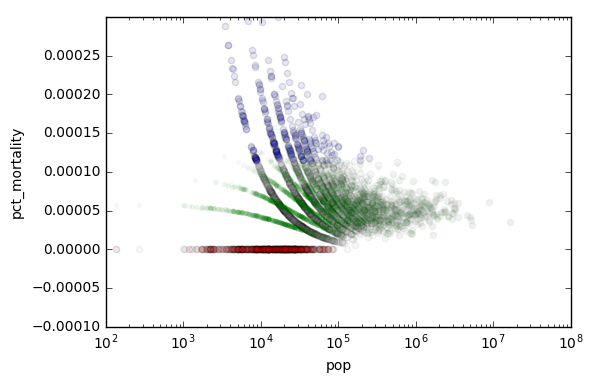

In [29]:
scatter_plot_cancer_rates(df, theta_post_mean)
plt.show()

We see that the cancer death rates obtained from our Bayesian model (plotted in green) gives more stable estimates of cancer death rates for counties with low populations. That is the effect of adding a prior for $\theta_j$ is one of regularization.

### Part B: Full Bayes
Rather than estimating the hyperparameters $\alpha, \beta$ from the data, in a full Bayesian model we would put additional priors on quantities of which we are uncertain. That is, we can model the kidney cancer rates using a *hierarchical model*.
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Gamma(a, b)\\
\beta &\sim Gamma(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 


(1) Analytically derive the full conditional, up constants that are inconsequential for sampling, for each variable in the model. 
  
  A possible set of correct final forms of your conditionals looks like the following:
      
\begin{aligned}
p(\theta_j | y, \theta_{-j}, \alpha, \beta) &\propto Gamma\left(\theta_j; y_j + \alpha, \beta + 5n_j\right)\\
p(\alpha, \beta | y, \theta) &\propto \Gamma(\alpha)^{-N}\beta^{N\alpha}\prod_j \theta_j^{\alpha}  \exp\left\{ - \beta\sum_j \theta_j \right\} * Gamma\left(\alpha; a, b \right) * Gamma\left(\beta; c, d \right) \\
\end{aligned}



(2) Implement a Metropolis-Hastings-in-Gibbs sampler (like in rat tumors) to produce sets of theta-values, $\{ \theta_j: j = 1, \ldots, N\}$. Note that for updating some variables, you may need to use a Metropolis-Hastings step (see Rat Tumor example). 

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = \alpha_{\text{emperical bayes}}, \beta_0 = \beta_{\text{emperical bayes}}$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10
  
  We do not guarantee convergence after 100,000 sets of samples under these conditions. In fact, ***convergence in a untweaked sampler maybe unlikely after only 100,000 Gibbs sweeps***. 

  You are responsible for performing your own convergence tests and diagnostics.

  **Note:** to sanity check your implementation, you may wish to implement this model in PyMC3 and compare your results. Note that because you model is hand tuned to deal with the conditionals and to sample straight away from the Gamma's, it will likely run faster)
  
  

- **Extra Credit:** Tweak the settings in your sampler (including number of sweeps) in order to achieve convergence. For example, do you need to sample $\alpha$ and $\beta$ jointly? Can sampling them individually speed up your sampler? Only do this after you have a complete homework. It is a rabbit hole.



(3) Using your samples, produce a pct mortality vs county population scatter plot exactly as in Part A.

**Solutions:**
Finding appropriate values for $\alpha, \beta$ using Emperical Bayes is algebraically involved and the practice itself runs counter to some people's beliefs regarding how Bayesian inference ought to be done. So what is the alternative? How else can we set values for $\alpha, \beta$? Well, if we're not certain about the values of $\alpha, \beta$, we should choose probability distributions for these quantities to capture our sense of uncertainty - i.e. we need to put priors on them. 

### 1. Full Conditionals
Before we derive the full conditionals, let's introduce some notation to simplify expressions. Let
\begin{align}
\theta &:= \{ \theta_j\}_{j=1, \ldots, N}\\
\theta_{-j} &:= \{ \theta_j\}_{j=1, j-1, j,\ldots, N}\\
y &:= \{y_j \}_{j=1, \ldots, N}\\
y_{-j} &:= \{ y_j\}_{j=1, j-1, j,\ldots, N}\\
\end{align}
The joint distribution of the variables in our hierarchical model is
$$
p(\theta, y, \alpha, \beta) = \prod_j \left[Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)\right]Gamma(a, b)Gamma(c, d).
$$
Thus, $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ can be written
\begin{align}
p(\theta_j | \theta_{-j}, y, \alpha, \beta) &\propto Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)\\
&\propto Gamma(\theta_j; \alpha + y_j, 5 n_j  + \beta),
\end{align}
and $p(\alpha, \beta | \theta, y)$ can be written
\begin{align}
p(\alpha, \beta | \theta, y) &\propto \left[\prod_j Gamma(\theta_j; \alpha, \beta)\right] Gamma(a, b)Gamma(c, d)\\
&\propto \prod_j \left[\frac{\beta^\alpha}{\Gamma(\alpha)} \theta_j^{\alpha - 1} e^{-\beta\theta_j}\right] \alpha^{a-1} e^{-b\alpha} \beta^{c-1} e^{-d\beta}\\
&= \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}
\end{align}
Unfortunately, you see that $p(\alpha, \beta | \theta, y)$ doesn't resemble the pdf of a nice simple distribution; that is, it is unclear how to sample from it.

### 2. Metropolis in Gibbs Sampling
Once we have the full conditionals, we can sample from our model by alternatingly sampling from each conditional. That is, we

1. sample $\theta_j$ from $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ for $j=1, \ldots, N$
2. sample a pair $(\alpha, \beta)$ from $p(\alpha, \beta | \theta, y)$, using the values of $\theta$ sampled from Step 1. 

Sampling from $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ is simple, since it involves sampling from a Gamma distribution. However, sampling from $p(\alpha, \beta | \theta, y)$ is difficult. As we noted from above, $p(\alpha, \beta | \theta, y)$ does not appear to be a known simple distribution. Thus, to sample from $p(\alpha, \beta | \theta, y)$, we will use a Metropolis-Hastings algorithm. That is, our Gibbs sampling will involve:

1. sample $\theta_j$ from $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ for $j=1, \ldots, N$, by sampling from $Gamma(\theta_j; \alpha + y_j, 5 n_j  + \beta)$
2. sample a pair $(\alpha, \beta)$ from $p(\alpha, \beta | \theta, y)$, using Metropolis-Hastings and the values of $\theta$ sampled from Step 1. 

For our Metropolis-Hastings step, we will use a bivariate normal proposal distribution.

In [76]:
#set hyperparameters
a = 9
b = 6
c = 9
d = 0.00001
sigma_alpha = 0.1
sigma_beta = 1000

#set observed variables
N = len(df)
n = df['pop'].values
y = df['dc'].values

#Function for sampling a theta for a particular county
draw_theta = lambda y_j, n_j, alpha, beta: np.random.gamma(y_j + alpha, scale=1. / (5. *  n_j + beta))

#The joint pdf of alpha and beta
p_alpha_beta = lambda alpha, beta, theta: np.log(sp.stats.gamma.pdf(alpha, a, scale=1. / b)) \
                                          + np.log(sp.stats.gamma.pdf(beta, c, scale=1. / d)) \
                                          + alpha * np.log(theta).sum() - beta * theta.sum() \
                                          + N * alpha * np.log(beta) \
                                          - N * np.log(sp.special.gamma(alpha))                 
                
#Function for sampling a pair (alpha, beta) using Metropolis-Hastings
def draw_alpha_beta(alpha, beta, y, theta, steps):
    #initialization 
    old_alpha = alpha
    old_beta = beta
    accept = 0
    
    for step in range(steps):
        #propose a pair (alpha, beta)
        new_alpha, new_beta = np.random.multivariate_normal([old_alpha, old_beta], [[sigma_alpha, 0], [0, sigma_beta]], 1)[0]
        #compute the log of the ratio of pdf's evaluated at the new and old alpha, beta values
        log_accept_frac = p_alpha_beta(new_alpha, new_beta, theta) - p_alpha_beta(old_alpha, old_beta, theta)
        #Accept mechanism
        if np.log(np.random.uniform()) < log_accept_frac:
            old_alpha = new_alpha
            old_beta = new_beta
            accept += 1
            
    return old_alpha, old_beta, accept * 1. / steps
    
#Gibbs Sampling
def gibbs(y, n, alpha_init, beta_init, theta_init, iters, burn, thin=1):   
    #initialization 
    alpha = [alpha_init]
    beta = [beta_init]
    theta = theta_init
    accept_alpha_beta = 0
    samples = [theta]
    
    
    for i in range(iters):
        if i % 5000 == 0:
            print i
            
        #draw alpha, beta
        alph, bet, accept = draw_alpha_beta(alpha[-1], beta[-1], y, theta, 1)
        alpha.append(alph)
        beta.append(bet)
        
        accept_alpha_beta += accept

        #draw theta
        theta = draw_theta(y, n, alpha[-1], beta[-1])
        samples.append(theta)
        
    return np.array(samples[int(burn * iters)::thin]), accept_alpha_beta / iters, alphas[int(burn * iters)::thin], betas[int(burn * iters)::thin]

In [77]:
#Initialize all parameters
alpha_init = alpha
beta_init = beta
theta_init = draw_theta(y, n, alpha_init, beta_init)

#Sample 100,000 samples with burn-in of 20% and thinning of 2
iters = 100000
thin = 20
burn = 0.2
samples, accept_rate, alphas, betas = gibbs(y, n, alpha_init, beta_init, theta_init, iters, burn, thin=thin)
print '\n\nAccept rate of M-H step:', accept_rate

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


Accept rate of M-H step: 0.08513


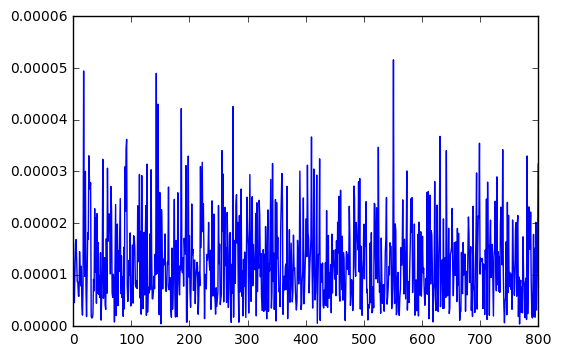

In [78]:
theta_0 = samples[:, 2000]
plt.plot(range(len(theta_0[::5])), theta_0[::5])
plt.show()

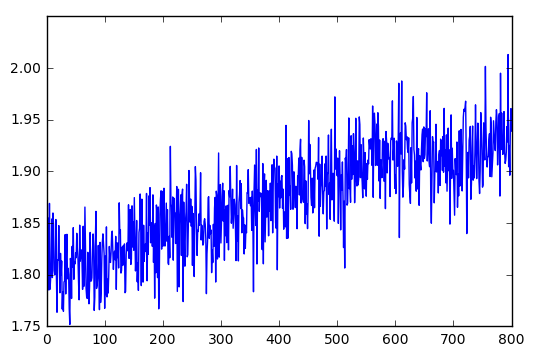

In [79]:
plt.plot(range(len(alphas[::5])), alphas[::5])
plt.show()

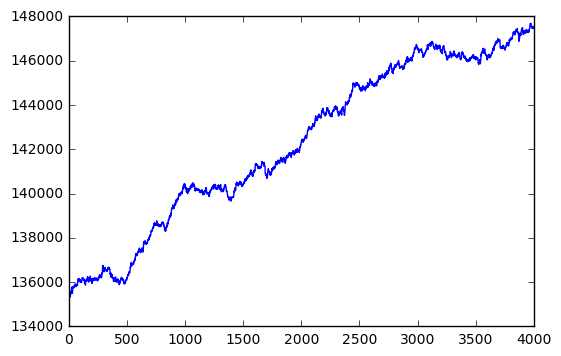

In [80]:
plt.plot(range(len(betas)), betas)

There are a couple of things to note: 

1. Our sampler has not converged after 100,000 sweeps. This is evident in the trends from the traceplots of alpha and beta.
2. The acceptance rate in the M-H step is low. 

Now, to simplify the amount of derivations we had to do, we made an earlier choice to jointly sample $\alpha$ and $\beta$. But since the values of $\beta$ are so large, it tends to dominate in the ratio of pdf's. One way to improve our sampler may be to sample $\alpha$ and $\beta$ separately (some of you have made this modification with successful results). Other changes one can make include changing the proposal distribution and the settings of the hyperparameters.

So what is the point of building this hiearchical model and sampling from it? Recall the idea is to produce, yet again, better estimates of the cancer death rates (especially for counties with lower populations). Thus, we are interested in how the theta values obtained from our hiearchical model compare with those obtained in Problem 1 and with the empirical cancer death rates. 

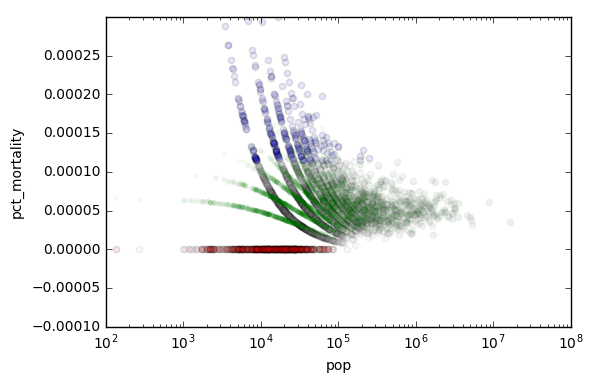

In [65]:
mean_theta_samples = np.array(samples).mean(axis=0)
scatter_plot_cancer_rates(df, mean_theta_samples)
plt.show()

We see that the mean theta values from our hierachical model also show shrinkage. That it, the theta values for counties with low population are less extreme than the empirical death rates. But the shrinkage is similiar to that we obtained from Problem 1 using Empirical Bayes. 

Note, this does not imply that model parameter estimates from Empirical Bayes are equivalent to or are better than those from full hierarchical models! Afterall, our sampler for the full hierarchical model did not converge! In fact, when converged, samples from the full hierachical model will typically show further shrinkage.